In [3]:
from langchain_groq.chat_models import ChatGroq
import pprint
from dotenv import load_dotenv
import os


llm = ChatGroq(model="llama-3.1-8b-instant", api_key=os.getenv("GROQ_API_KEY"))

prompt = "What is the capital of France?"
response = llm.invoke(prompt)
pprint.pprint(response.content)

'The capital of France is Paris.'


In [4]:
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage, ChatMessage
from langgraph.graph import StateGraph, END
from langchain_groq.chat_models import ChatGroq
from dotenv import load_dotenv
import os

load_dotenv()

model = ChatGroq(model="llama-3.1-8b-instant", api_key=os.getenv("GROQ_API_KEY"))

In [5]:
# Defining Agent State

from typing import TypedDict, List, Annotated, Dict, Union

# Creating class for the agent state
class AgentState(TypedDict):
    task: str
    plan: str
    abstract: str
    keywords: List[str]
    introduction: str
    research_objectives: List[str]
    literature_review: str
    research_methodology: str
    technology_used: str
    comparative_analysis: str
    future_outcomes: str
    future_objectives: List[str]
    conclusion: str
    references_cited: List[str]
    bibliography: List[str]
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int    

In [6]:
from pydantic import BaseModel
from tavily import TavilyClient

class Queries(BaseModel):
    queries: List[str]  

tavily = TavilyClient(api_key=os.getenv("TAVILY_API"))

{'properties': {'title': {'description': 'Title of the research paper',
   'title': 'Title',
   'type': 'string'},
  'authors': {'description': 'Authors of the research paper',
   'items': {'type': 'string'},
   'title': 'Authors',
   'type': 'array'},
  'affiliation': {'description': 'Affiliation of the authors',
   'items': {'type': 'string'},
   'title': 'Affiliation',
   'type': 'array'},
  'abstract': {'description': 'Abstract of the research paper',
   'title': 'Abstract',
   'type': 'string'},
  'keywords': {'description': 'Keywords of the research paper',
   'items': {'type': 'string'},
   'title': 'Keywords',
   'type': 'array'},
  'introduction': {'description': 'Introduction of the research paper',
   'title': 'Introduction',
   'type': 'string'},
  'related_work': {'description': 'Related work of the research paper',
   'title': 'Related Work',
   'type': 'string'},
  'research_objectives': {'description': 'Research objectives of the research paper',
   'title': 'Research O

In [7]:
# Create a Planner Node/Agent
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of a research paper.
Write such an outline for the user provided topic.
Give an outline of the research paper for theses following topics:
[0] Title
[1] Abstract
[2] Keywords
[3] Introduction
[5] Research Objectives
[4] Literature Review
[6] Research Methodology
[7] Technology Used
[8] Comparative Analysis
[9] Future Outcomes
[10] Future Objectives
[11] Conclusion
[12] References Cited
[13] Bibliography
"""
# Create a Planner Node/Agent
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state["task"]),
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [39]:
# Research Planner Node/Agent
RESEARCH_PLANNER_PROMPT = """You are a research planner charged with providing that can be used to generate a research plan.
Generate the list of search queries that will help to gather the relevant information for the research paper.
- Only generate 5 queries max.
- Each query should be a single line.
"""
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        SystemMessage(content=RESEARCH_PLANNER_PROMPT),
        HumanMessage(content=f"Here are the tasks: {state['task']}")
    )
    
    content = state.get("content", [])
    
    for query in queries.queries:
        response = tavily.search(query=query, max_results=5)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [40]:
# Abstract Generator Node/Agent
ABSTRACT_PROMPT = """You are an abstract writer tasked with writing an abstract for a research paper.
Write an abstract of 300-500 words for the given topic and provided content: {content}
- The abstract should be concise and informative.
- The abstract should highlight the key findings and contributions of the research paper.
- The abstract should be written in a clear and engaging style.
- The abstract should be written in a way that is easy to understand for a general audience.
- The abstract should be written in a way that is consistent with the style of the research paper.
- It should be more than 300 words and less than 500 words.
- Abstract should be focusing the true problem statement of the provided content.
"""

# Generate Abstract Node/Agent
def abstract_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\nHere is the plan:\n{state['plan']}\nHere is the content:\n{content}"
    )
    
    messages = [
        SystemMessage(
            content=ABSTRACT_PROMPT.format(content=content)
        ),
        user_message
    ]
    
    response = model.invoke(messages)
    
    return {
        "abstract": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }

In [41]:
# Keywords Generator Node/Agent
KEYWORDS_PROMPT = """You are a keyword generator tasked with writing keywords for a research paper.
The keywords should be relevant to the research paper's topic and should be written in a way that is easy to understand.
You should write the keywords in a list format.
Note: Keywords should be separated by commas and relevant to the research paper's topic.
"""

# Generate Keywords Node/Agent
def keywords_node(state: AgentState):
    user_message = HumanMessage(
        content=f"{state['task']}\nHere is the Plan:\n{state['plan']}\nHere is the Abstract:\n{state['abstract']}\nHere is the content:\n{state['content']}"
    )
    
    messages = [
        SystemMessage(
            content=KEYWORDS_PROMPT
        ),
        user_message
    ]
    
    response = model.invoke(messages)
    
    return {
        "keywords": response.content.split(","),
        "revision_number": state.get("revision_number", 1) + 1,
    }

In [42]:
# Reflection Agent
REFLECTION_AGENT_PROMPT = """You are a Researcher who is an expert in validating research papers.
You are given an Abstract and Its Keywords and you need to validate them.
You need to validate the Abstract and Keywords by checking these following criteria:
- Is the abstract concise and informative?
- Is the abstract free of jargon and technical terms?
- Does the abstract provide a clear and concise summary of the research?
- Is there any missing information in the abstract?
- Is there any irrelevant information in the abstract?
- Is the grammar and spelling correct in the abstract?
- Is there any AI generated content in the abstract?
- Is there any need of paraphrasing in the abstract?
- Is there any need of adding more information in the abstract?
"""

# Reflection Agent Node
def reflection_agent_node(state: AgentState):
    messages = [
        SystemMessage(
            content=REFLECTION_AGENT_PROMPT
        ),
        HumanMessage(
            content=f"Here is the Abstract:\n{state['abstract']}\nHere are the Keywords:\n{state['keywords']}"
        )
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [43]:
# Research Critique Agent
RESEARCH_CRITIQUE_PROMPT = """You are a research critique agent charged with providing more information that can be used when 
making any request revisions (as outlined below):
Generate list of queries that will gather more relevant information for the research paper. Generate Only 3 queries max.
"""

# Research Critique Agent Node
def research_critique_agent(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state["critique"])
    )
    content = state["content"] or []
    for query in queries.queries:
        response = tavily.search(query=query, max_results=5)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [44]:
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'

In [45]:
builder = StateGraph(AgentState)

builder.add_node('planner', plan_node)
builder.add_node('research_planner', research_plan_node)
builder.add_node('abstract_generator', abstract_node)
builder.add_node('keyword_generator', keywords_node)
builder.add_node('reflection', reflection_agent_node)

builder.add_node('critiques', research_critique_agent)

builder.set_entry_point('planner')

builder.add_conditional_edges(
    'research_planner',
    should_continue,
    {END:END, 'reflect': 'reflection'},
)

builder.add_edge('planner', 'research_planner')
builder.add_edge('research_planner', 'abstract_generator')
builder.add_edge('abstract_generator', 'keyword_generator')
builder.add_edge('keyword_generator', 'reflection')
builder.add_edge('reflection', 'critiques')
builder.add_edge('critiques', 'research_planner')
builder.add_edge('research_planner', 'abstract_generator')
builder.add_edge('abstract_generator', 'keyword_generator')

In [46]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(':memory:')

graph = builder.compile(checkpointer=MemorySaver())

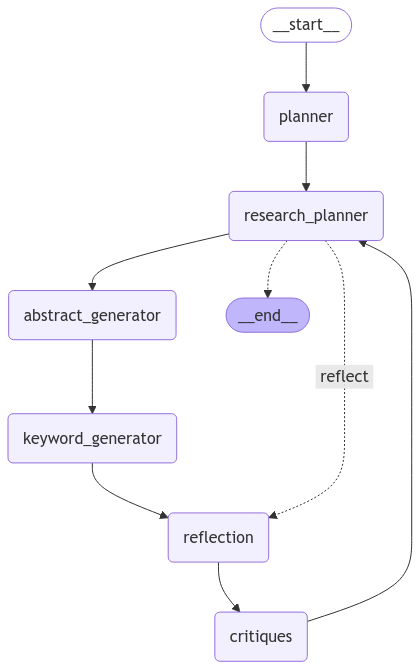

In [47]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
thread = {'configurable': {'thread_id': '1'}}
task = 'Future of Artificial General Intelligence and its use cases in the future'

prompt = {
    'task': task,
    'max_revisions': 5,
    'revision_number': 1,
}

In [49]:
event = graph.stream(prompt, thread)
for e in event:
    print(e)
    print('-'*150)

{'planner': {'plan': "**Title:** The Future of Artificial General Intelligence: Exploring its Potential and Applications\n\n**I. Abstract**\n\n* Brief overview of the paper's focus on Artificial General Intelligence (AGI) and its future applications\n* Highlights the significance of AGI in transforming industries and revolutionizing human life\n* Provides a glimpse into the paper's main arguments and conclusions\n\n**II. Keywords**\n\n* Artificial General Intelligence (AGI)\n* Machine Learning (ML)\n* Deep Learning (DL)\n* Artificial Intelligence (AI)\n* Future Applications of AGI\n\n**III. Introduction**\n\n* Definition and explanation of AGI\n* Importance of AGI in the modern era\n* Current state of AGI research and development\n* Thesis statement: AGI has the potential to revolutionize various industries and aspects of human life in the future\n\n**IV. Literature Review**\n\n* Overview of existing research on AGI and its applications\n* Discussion of the benefits and challenges of A

AttributeError: 'HumanMessage' object has no attribute 'items'